# Collars
Price collars using different models. If vanillas match, we expect collars to match as well. Consider this notebook as a prequel to the note book on [Forward Collars](03b_FwdCollars.ipynb).

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import pyarrow as pa
from matplotlib import pyplot as plt
from qablet.black_scholes.mc import LVMCModel
from qablet.heston.mc import HestonMCModel
from qablet_contracts.timetable import TS_EVENT_SCHEMA

from data.spx_2005_09_15 import (
    heston_data,
    localvol_data,
    rbergomi_data,
    basic_info,
)
from src.model.rbergomi import rBergomiMCModel

In [2]:
# We will compare everything with the SVI implied volatilities on 2005-09-15
info = basic_info()
prc_dt = info["prc_dt"]
ticker = info["ticker"]
spot = info["spot"]

# We will use a collar width of 1%
width = 0.01 * spot

### Collars
Collars are not in the qablet_contracts package. We will write a method to create collars here, using the [qablet specifications](https://qablet.github.io/qablet-contracts/specifications/timetable/). A collar pays at maturity, based on a cap and floor from a collar width.

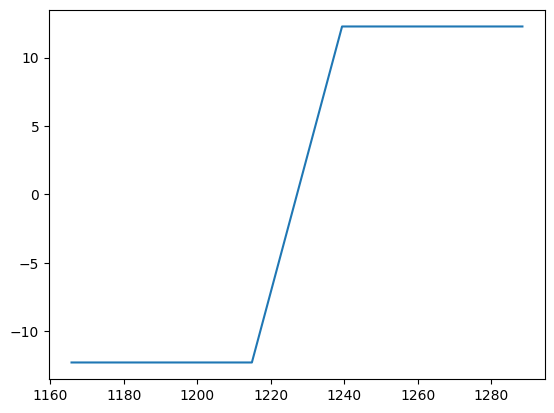

In [3]:
# Define collar phrase, which is spot - K, capped and floored.
strike = spot


def collar_pay_fn(inputs):
    [s] = inputs

    ret = np.maximum(-width, s - strike)
    ret = np.minimum(width, ret)

    return [ret]


# let's plot the collar payoffs
s_vec = np.linspace(strike - 0.05 * spot, strike + 0.05 * spot, 11)
pay_vec = collar_pay_fn([s_vec])
plt.plot(s_vec, pay_vec[0])

In [4]:
# Create a Collar timetable using the above collar fn
def collar_timetable(ticker, maturity):
    events = [
        {
            "track": "",
            "time": maturity,
            "op": "+",
            "quantity": 1,
            "unit": "COLLAR",
        },
    ]

    events_table = pa.RecordBatch.from_pylist(events, schema=TS_EVENT_SCHEMA)
    return {
        "events": events_table,
        "expressions": {
            "COLLAR": {
                "type": "phrase",
                "inp": [ticker],
                "fn": collar_pay_fn,
            },
        },
    }


# Try an example:
timetable = collar_timetable(ticker, datetime(2013, 12, 31))
print(timetable["events"].to_pandas())

  track                      time op  quantity    unit
0       2013-12-31 00:00:00+00:00  +       1.0  COLLAR


Create a series of collars starting at different expiration dates.

In [7]:
exp_dates = []
timetables = []
for i in range(6):
    exp_dt = prc_dt + pd.DateOffset(months=2 * i + 2)
    exp_dates.append(exp_dt)
    timetables.append(
        collar_timetable(
            ticker,
            maturity=exp_dt,
        )
    )
df = pd.DataFrame({"exp date": exp_dates})
df

,exp date
0,2005-11-14
1,2006-01-14
2,2006-03-14
3,2006-05-14
4,2006-07-14
5,2006-09-14


### Compare Models
Compare different models, starting with Local Volatility Model.

In [8]:
model = LVMCModel()

prices = []
for timetable in timetables:
    price, _ = model.price(timetable, localvol_data())
    prices.append(price)

df["LocalVol"] = prices
df

,exp date,LocalVol
0,2005-11-14,2.625258
1,2006-01-14,2.897869
2,2006-03-14,3.051252
3,2006-05-14,3.151917
4,2006-07-14,3.202866
5,2006-09-14,3.218140


Heston Model

In [9]:
model = HestonMCModel()

prices = []
for timetable in timetables:
    price, _ = model.price(timetable, heston_data())
    prices.append(price)
df["Heston"] = prices
df

,exp date,LocalVol,Heston
0,2005-11-14,2.625258,2.299740
1,2006-01-14,2.897869,2.839489
2,2006-03-14,3.051252,3.086085
3,2006-05-14,3.151917,3.206615
4,2006-07-14,3.202866,3.247730
5,2006-09-14,3.218140,3.278776


Bergomi Model

In [10]:
model = rBergomiMCModel()
dataset = rbergomi_data()
dataset["MC"]["PATHS"] = 20_000  # very slow with 100_000, 1/250
dataset["MC"]["TIMESTEP"] = 1 / 100

prices = []
for timetable in timetables:
    price, _ = model.price(timetable, dataset)
    prices.append(price)
df["rBergomi"] = prices
df

,exp date,LocalVol,Heston,rBergomi
0,2005-11-14,2.625258,2.299740,2.605350
1,2006-01-14,2.897869,2.839489,3.018518
2,2006-03-14,3.051252,3.086085,3.180562
3,2006-05-14,3.151917,3.206615,3.252619
4,2006-07-14,3.202866,3.247730,3.339039
5,2006-09-14,3.218140,3.278776,3.331857


## Plot

<Axes: title={'center': 'Collar Prices'}, xlabel='exp date'>

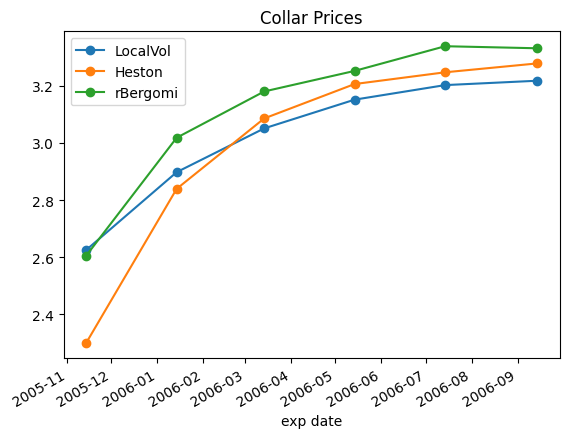

In [11]:
df.columns
df.plot(
    x="exp date",
    y=["LocalVol", "Heston", "rBergomi"],
    marker="o",
    title="Collar Prices",
)